In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys

sys.path.append("../")

import os
from typing import List
from matplotlib import pyplot as plt

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

from src.datasets.sequence_dataset import SequenceDataset
from src.config import SAMPLES_PATH
from src.utils.file import get_files_recursive

SEQUENCE_LENGTH = 5

In [27]:
def get_sample_path_files() -> List[List[str]]:
    """
    Get sample files and group by folder
    
    Returns:
    List[List[str]]: List of list of sample files
    """
    sample_paths_list = get_files_recursive(SAMPLES_PATH, "*.pkl")
    sample_paths_dict = {}
    for path in sample_paths_list:
        folder_path = "/".join(path.split("/")[:-1])
        if folder_path not in sample_paths_dict:
            sample_paths_dict[folder_path] = []
        sample_paths_dict[folder_path].append(path)
    sample_paths_list = list(sample_paths_dict.values())

    return sample_paths_list
sample_paths_list = get_sample_path_files()

In [28]:
dataset = SequenceDataset(
    sample_paths_list=sample_paths_list,
    sequence_length=SEQUENCE_LENGTH,
)

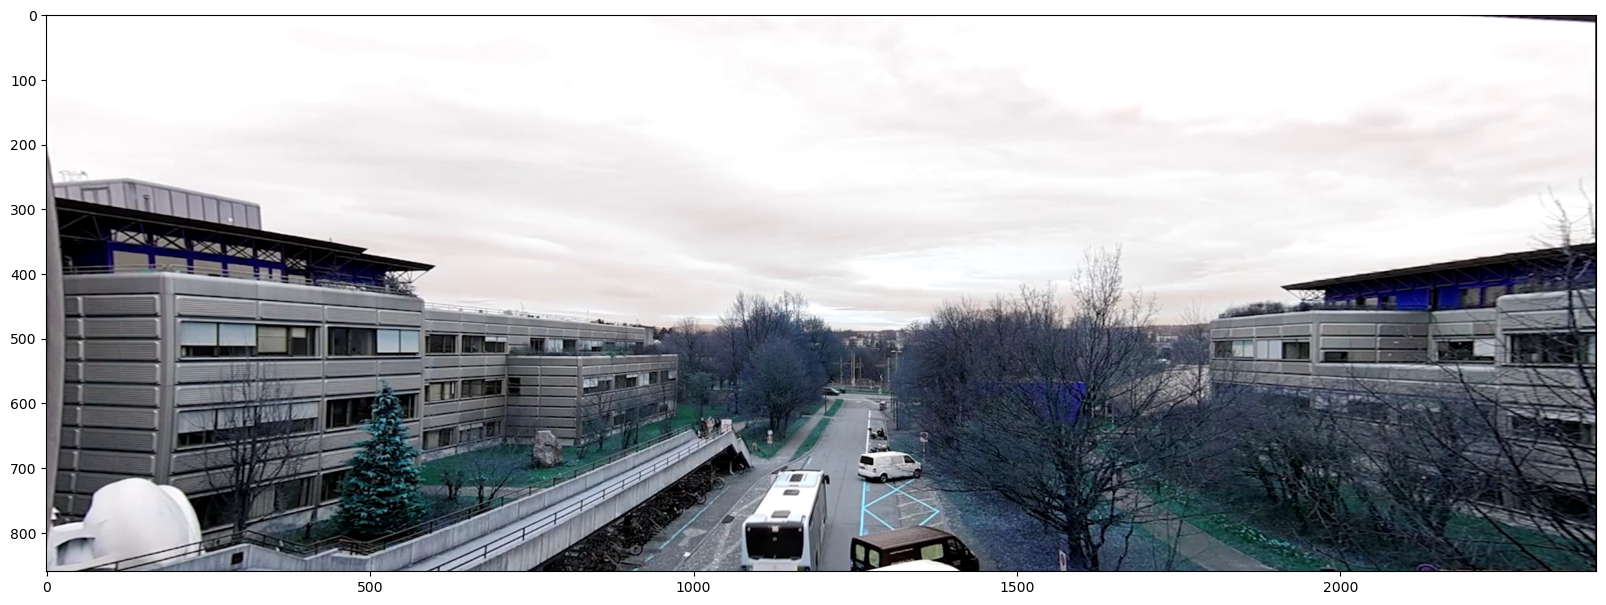

In [29]:
plt.figure(figsize=(20, 10))
plt.imshow(dataset[6][0].image_series[0])
plt.show()

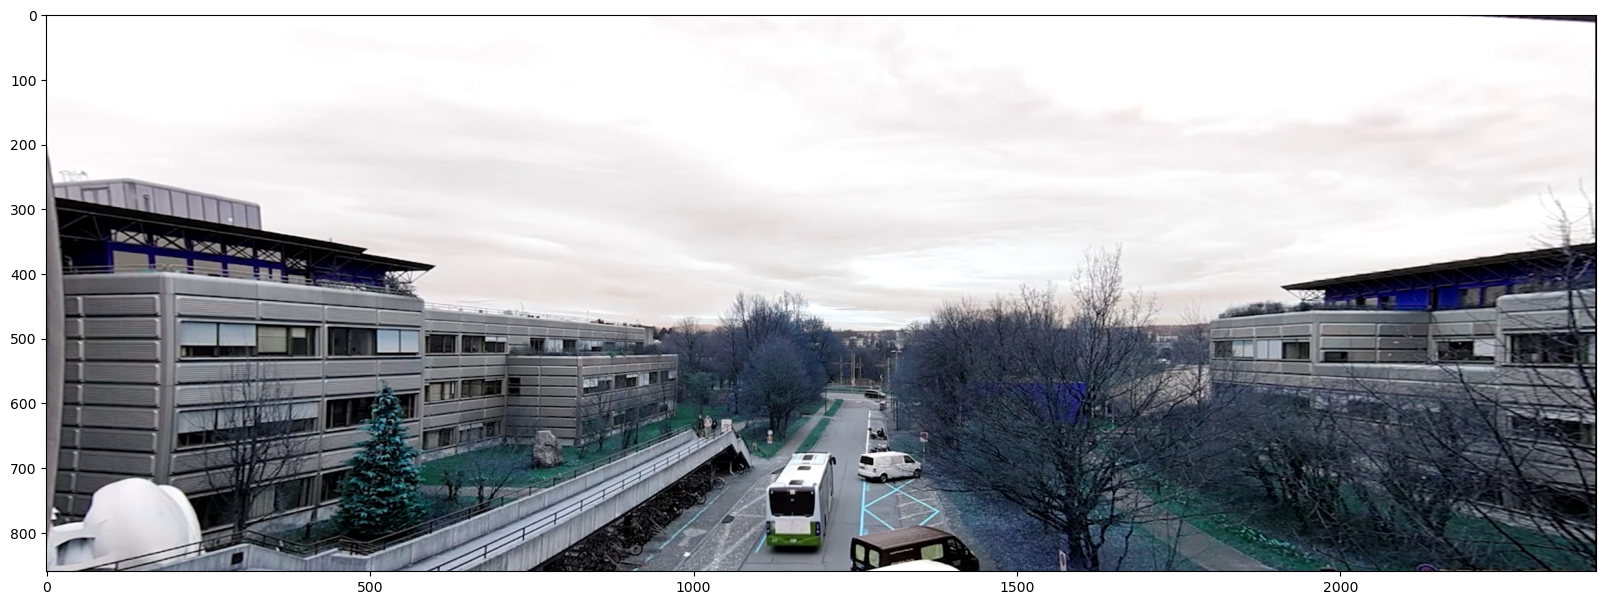

In [30]:
plt.figure(figsize=(20, 10))
plt.imshow(dataset[6][0].image_series[4])
plt.show()

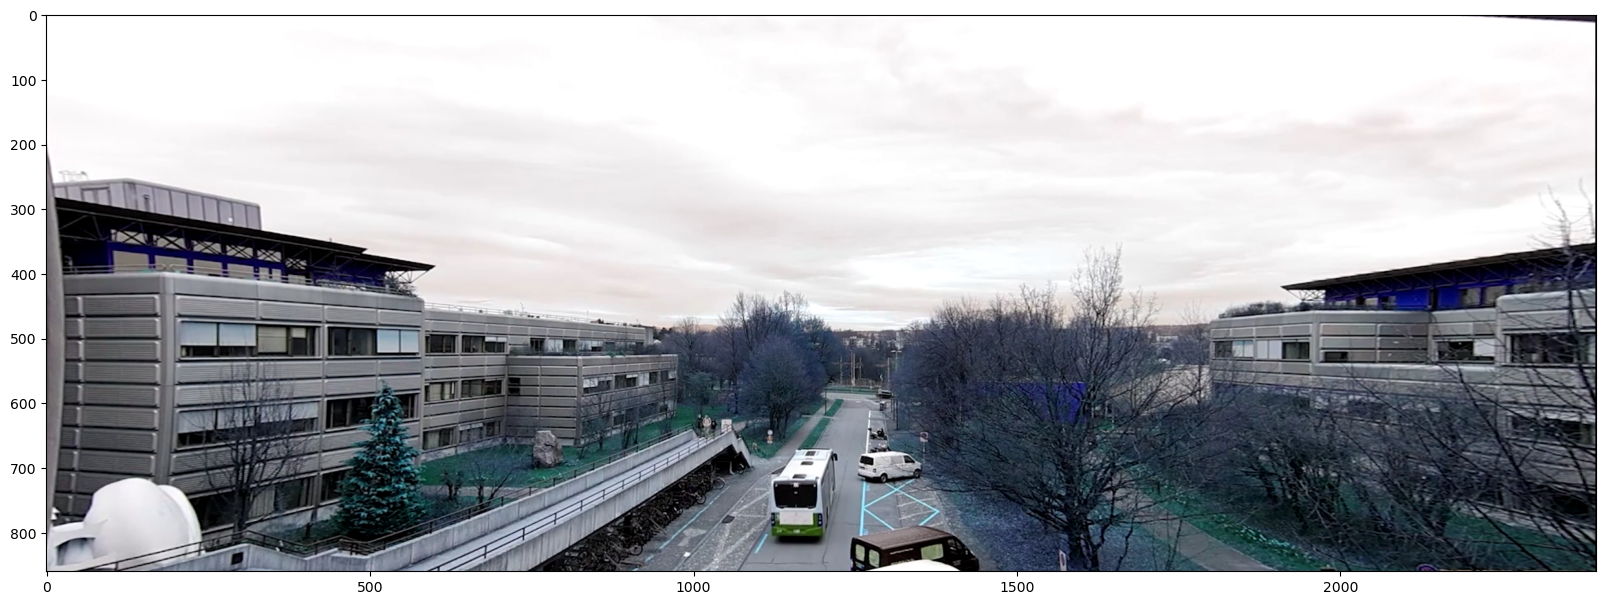

In [31]:
plt.figure(figsize=(20, 10))
plt.imshow(dataset[6][0].next_image)
plt.show()